<a href="https://colab.research.google.com/github/Pseudophoenix/Sentiment-Analysis/blob/main/Sentiment_Analysis_using_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [76]:
import tensorflow_datasets as tfds, re, numpy as np
import os, string, tensorflow as tf
from tensorflow.keras.layers import TextVectorization, Input, Embedding, SimpleRNN, Dense

### Data Preparation

In [5]:
train_ds,val_ds,test_ds=tfds.load("imdb_reviews",split=['train','test[:50%]','test[50%:]'],as_supervised=True)

The `take(n)` method efficiently retrieves a small subset (n elements) from a dataset without loading the entire dataset, making it useful for quick debugging or sampling.

`take(5):` Streams only 5 batches/samples, avoiding full dataset iteration.

In [72]:
for review,label in train_ds.take(5):
  print(len(tf.strings.split(review,sep=" ")))
  print(review)
  print(label)

116
tf.Tensor(b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.", shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)
112
tf.Tensor(b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. Howe

As shown above two sentiments positive and negative for a given review

    "<[^>]+>" is a regular expression that matches HTML tags:

    < matches the opening angle bracket

    [^>]+ matches one or more characters that are NOT closing angle brackets

    > matches the closing angle bracket

    Pattern: "[%s]" % re.escape(string.punctuation) creates a regex pattern that matches any punctuation character

    string.punctuation is a string containing all common punctuation marks (!"#$%&'()*+,-./:;<=>?@[\]^_{|}~`)

    re.escape() ensures special regex characters are properly escaped

    The [ ] makes it a character class, meaning "match any of these characters"

In [20]:
def standardization(input_data):
  """
  Input: raw reviews may be fetched from any API, website scrapped, or anything else
  Output: standardized reviews
  """
  lowercase=tf.strings.lower(input_data) # convert to lowercase
  no_tag=tf.strings.regex_replace(lowercase,"<[^>]+>","") # replace html tags with nothing
  output=tf.strings.regex_replace(no_tag,"[%s]"%re.escape(string.punctuation),"") # replace punctuation symbols with "" nothing
  return output

In [21]:
standardization(tf.constant("<u>In the movie?, </u>man called Tévèz, went to a friend’s pl**ce and they had a tensed discussion. I don’t love this movie! would you?<br> <br /><br />T"))

<tf.Tensor: shape=(), dtype=string, numpy=b'in the movie man called t\xc3\xa9v\xc3\xa8z went to a friend\xe2\x80\x99s plce and they had a tensed discussion i don\xe2\x80\x99t love this movie would you t'>

In [22]:
VOCAB_SIZE=10000
SEQUENCE_LENGTH=250
EMBEDDING_DIM=300

Tokenization and numericalization have been wrapped into just one layer of `tf` `TextVectorization layer`

We have created our custom standardize function, we could have used 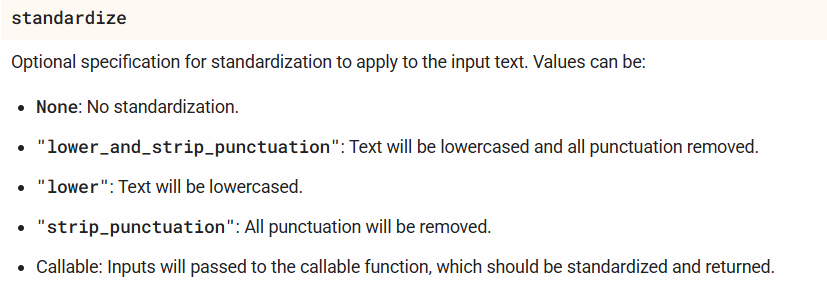

In [112]:
vectorize_layer=TextVectorization(
    standardize=standardization,
    max_tokens=VOCAB_SIZE,
    # output_mode='int',
    output_mode='multi_hot' #-> ONE HOT REPRESENTATION
    # output_sequence_length=SEQUENCE_LENGTH
)

In [123]:
vectorize_layer=TextVectorization(
    standardize=standardization,
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    # output_mode='multi_hot' #-> ONE HOT REPRESENTATION
    output_sequence_length=SEQUENCE_LENGTH
)

To simply not guess the VOCAB_SIZE and SEQUENCE_LENGTH take a deeper look into the dataset

In [124]:
lengths=[] # length of each reviews that is the number of words
words=[] # will contain the vocabulary words from the first 10 reviews
for review,label in train_ds.take(100):
    # for word in tf.strings.split(review,sep=" "):
    #   if word in words:
    #     pass
    #   else:
    #     words.append(word)
    lengths.append(len(tf.strings.split(review,sep=" ")))

In [125]:
print(lengths)#,words

[116, 112, 132, 88, 81, 289, 557, 111, 223, 127, 164, 277, 545, 141, 332, 84, 312, 420, 267, 333, 186, 306, 255, 118, 196, 128, 169, 160, 163, 148, 229, 484, 207, 111, 81, 218, 121, 188, 106, 127, 128, 450, 454, 94, 145, 103, 170, 481, 192, 280, 70, 231, 39, 233, 136, 136, 289, 714, 209, 155, 161, 257, 235, 151, 277, 122, 264, 98, 177, 413, 251, 71, 115, 50, 170, 121, 367, 126, 163, 168, 133, 92, 745, 140, 184, 255, 64, 263, 188, 136, 161, 545, 77, 55, 863, 117, 68, 159, 138, 125]


In [126]:
np.mean(lengths)

np.float64(213.86)

Average comes out to be `213` so we can take `SEQUENCE_LENGTH=250`

Now we want this TextVectorization layer to adapt to our dataset that is analyzes the text data to build a vocabulary (mapping tokens like words or characters to integer indices)

In [127]:
training_data=train_ds.map(lambda x,y:x) # review, label : review
vectorize_layer.adapt(training_data)

In [128]:
vectorize_layer.get_vocabulary()

['',
 '[UNK]',
 np.str_('the'),
 np.str_('and'),
 np.str_('a'),
 np.str_('of'),
 np.str_('to'),
 np.str_('is'),
 np.str_('in'),
 np.str_('it'),
 np.str_('this'),
 np.str_('i'),
 np.str_('that'),
 np.str_('was'),
 np.str_('as'),
 np.str_('with'),
 np.str_('for'),
 np.str_('movie'),
 np.str_('but'),
 np.str_('film'),
 np.str_('on'),
 np.str_('not'),
 np.str_('are'),
 np.str_('you'),
 np.str_('his'),
 np.str_('have'),
 np.str_('be'),
 np.str_('he'),
 np.str_('one'),
 np.str_('its'),
 np.str_('at'),
 np.str_('all'),
 np.str_('by'),
 np.str_('an'),
 np.str_('they'),
 np.str_('who'),
 np.str_('from'),
 np.str_('like'),
 np.str_('so'),
 np.str_('her'),
 np.str_('or'),
 np.str_('just'),
 np.str_('about'),
 np.str_('has'),
 np.str_('out'),
 np.str_('if'),
 np.str_('some'),
 np.str_('what'),
 np.str_('there'),
 np.str_('good'),
 np.str_('more'),
 np.str_('very'),
 np.str_('when'),
 np.str_('she'),
 np.str_('even'),
 np.str_('up'),
 np.str_('no'),
 np.str_('would'),
 np.str_('my'),
 np.str_('whic

In [129]:
len(vectorize_layer.get_vocabulary())

10000

In [130]:
def vectorizer(review,label):
  return vectorize_layer(review),label

In [131]:
train_dataset=train_ds.map(vectorizer)
val_dataset=val_ds.map(vectorizer)

In [132]:
for i in range(1,20):
  print(f"{vectorize_layer.get_vocabulary()[i]} -> {i}")

[UNK] -> 1
the -> 2
and -> 3
a -> 4
of -> 5
to -> 6
is -> 7
in -> 8
it -> 9
this -> 10
i -> 11
that -> 12
was -> 13
as -> 14
with -> 15
for -> 16
movie -> 17
but -> 18
film -> 19


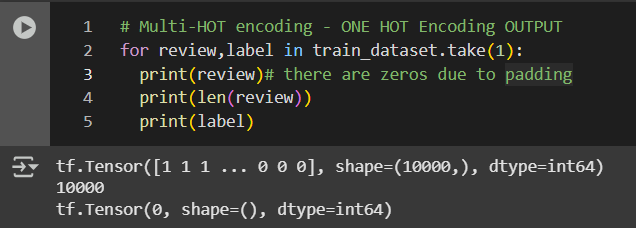

In [133]:
for review,label in train_dataset.take(1):
  print(review)# there are zeros due to padding
  print(len(review))
  print(label)

tf.Tensor(
[  10   13   33  411  384   17   89   26    1    8   32 1337 3521   40
  491    1  192   22   84  149   18   10  215  317   26   64  239  212
    8  484   54   64   84  111   95   21 5502   10   91  637  737   10
   17    7   33  393 9554  169 2443  406    2   87 1205  135   65  142
   52    2    1 7408   65  245   64 2832   16    1 2851    1    1 1415
 4969    3   39    1 1567   15 3521   13  156   18    4 1205  881 7874
    8    4   17   12   13 4037    5   98  145 1234   11  236  696   12
   48   22   91   37   10 7285  149   37 1337    1   49  396   11   95
 1148  841  140    9    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

Now we get a numericalized version of our review text

In [134]:
for review, label in train_ds.take(1):
  print(review)
  print(label)

tf.Tensor(b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.", shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)


In [135]:
vectorize_layer.get_vocabulary()[10],vectorize_layer.get_vocabulary()[13],vectorize_layer.get_vocabulary()[33],vectorize_layer.get_vocabulary()[411]

(np.str_('this'), np.str_('was'), np.str_('an'), np.str_('absolutely'))

In [136]:
BATCH_SIZE=64

- Prefetching for efficient loading

    - This code batches the training (train_dataset) and validation (val_dataset) datasets into groups of size BATCH_SIZE for efficient GPU processing and uses prefetch with tf.data.AUTOTUNE to overlap data preprocessing and model execution, improving training speed by loading the next batch of data in the background while the current batch is being processed by the model.

In [137]:
train_dataset=train_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset=val_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

## Modelling


### SimpleRNN

In [139]:
#               [BatchSize,SeqLength,VocabSize]
inputs=np.random.random([32,10,8]).astype(np.float32)
simple_rnn=tf.keras.layers.SimpleRNN(25) # output dimension of the SimpleRNN's output will be 25, # dimension of weight
output=simple_rnn(inputs)
print(output.shape)# 32 batches each of dimension 25

(32, 25)


10 words of 8 dimensions each

L1, L2, L3, L4, L5, L6, L7, L8, L9, L10 each of which are 8 dimensional vectors

In [75]:
output

<tf.Tensor: shape=(32, 25), dtype=float32, numpy=
array([[-5.85584104e-01,  1.48234367e-01,  7.67095834e-02,
        -3.56685191e-01,  4.22710516e-02,  5.26360095e-01,
         5.39524376e-01, -2.26860747e-01, -2.16872096e-01,
        -2.31887829e-02, -5.24803817e-01, -9.41619217e-01,
        -4.48756784e-01, -2.02991828e-01,  7.72438824e-01,
        -5.51414907e-01, -6.08040333e-01,  1.87081799e-01,
         3.72717023e-01, -1.10799737e-01,  2.83375502e-01,
        -6.72288120e-01,  2.77219236e-01, -2.55378634e-02,
        -1.63226560e-01],
       [-4.95803446e-01,  7.47569501e-01,  1.39400244e-01,
         1.64499938e-01, -2.24883005e-01, -2.00161904e-01,
         5.32289386e-01, -9.80560556e-02,  7.38141164e-02,
        -5.93130708e-01, -9.28184032e-01, -5.10742128e-01,
        -2.87480891e-01, -1.81575105e-01,  6.15101933e-01,
        -2.79482782e-01, -7.14963436e-01,  5.34263730e-01,
         4.72721368e-01,  3.50609004e-01,  2.13374645e-01,
        -1.05997287e-01, -4.70461324e-0

In [80]:
EMBEDDING_DIM=64
model=tf.keras.models.Sequential([
    Input(shape=(SEQUENCE_LENGTH,)),
    Embedding(VOCAB_SIZE,EMBEDDING_DIM),
    SimpleRNN(32),
    Dense(1,activation="sigmoid"),
])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 250, 64)        │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 643,137 (2.45 MB)

 Trainable params: 643,137 (2.45 MB)

 Non-trainable params: 0 (0.00 B)